In [1]:
import numpy as np
import pylab
import pandas as pd
import statsmodels.api as sm
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [19]:
model = sm.tsa.statespace.SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               Riders   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1132.688
Date:                              Mon, 22 Feb 2021   AIC                           2271.377
Time:                                      20:01:52   BIC                           2279.038
Sample:                                  01-31-1973   HQIC                          2274.473
                                       - 12-31-1981                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5561      0.132      4.206      0.000       0.297       0.815
ma.S.L12      -0.89

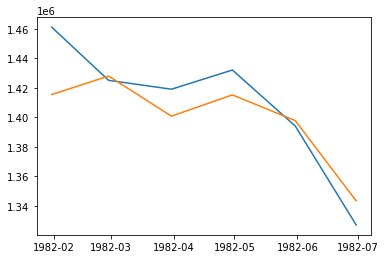

In [14]:
pylab.plot(test_data)
pylab.plot(model_fit.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True))

In [159]:
series

1973-01-31     6480000
1973-02-28     6460000
1973-03-31     6390000
1973-04-30     6540000
1973-05-31     6300000
                ...   
1982-02-28    14250000
1982-03-31    14190000
1982-04-30    14320000
1982-05-31    13940000
1982-06-30    13270000
Freq: M, Name: 0, Length: 114, dtype: int64

In [20]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = series[:train_end-timedelta(days=1)]
    model = sm.tsa.statespace.SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

Text(0, 0.5, 'Error')

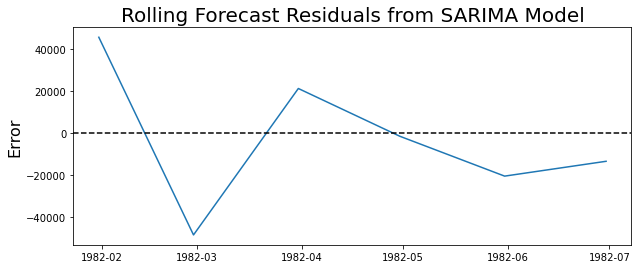

In [21]:
rolling_residuals = test_data - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)

<AxesSubplot:>

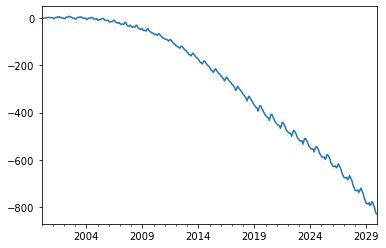

In [96]:
n = 12 * 30

startdate = '2000-01-01'
daterange = pd.date_range(start=startdate, periods=n, freq='M')

empty_dataset = np.zeros(n)
mod = SARIMAX(empty_dataset, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12), initialization='diffuse')
series = pd.Series(mod.simulate([0.2, 0.5, 1], n), index=daterange)
series.plot()

<AxesSubplot:>

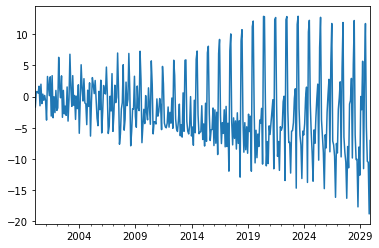

In [97]:
series.diff().dropna().plot()

<AxesSubplot:>

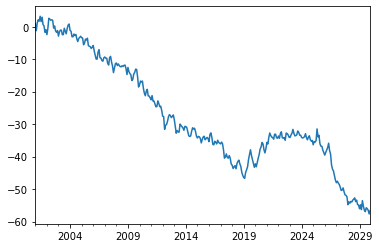

In [98]:
series.diff(12).dropna().plot()

<AxesSubplot:>

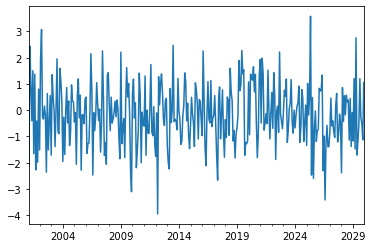

In [99]:
series.diff().diff(12).dropna().plot()

In [100]:
diffs = series.diff().diff(12).dropna()

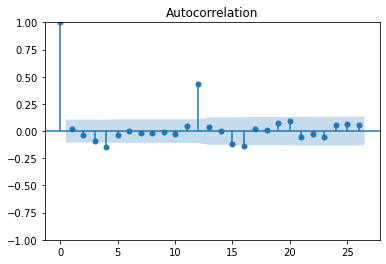

In [101]:
acf_plot = plot_acf(diffs)

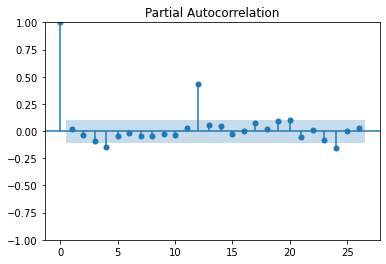

In [102]:
pacf_plot = plot_pacf(diffs, method='ywm')

In [103]:
train_end = datetime(2028, 1, 1)

train_data = series[:train_end]
test_data = series[train_end :]

In [106]:
model = sm.tsa.statespace.SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -462.882
Date:                              Thu, 03 Feb 2022   AIC                            931.764
Time:                                      20:59:48   BIC                            943.097
Sample:                                  01-31-2000   HQIC                           936.288
                                       - 12-31-2027                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0924      0.096      0.966      0.334      -0.095       0.280
ma.S.L12       0.53

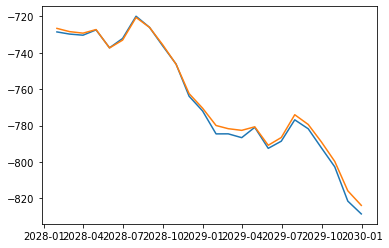

In [107]:
pylab.plot(test_data)
pylab.plot(model_fit.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True))

In [108]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = series[:train_end-timedelta(days=1)]
    model = sm.tsa.statespace.SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

Text(0, 0.5, 'Error')

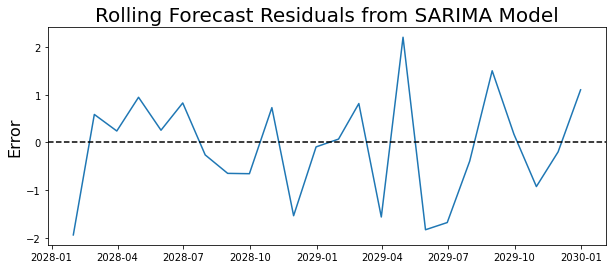

In [109]:
rolling_residuals = test_data - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)

For another example, see this analysis from Sean Abu https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

The ridership data can obtained here http://ftp.uni-bayreuth.de/math/statlib/general/tsa2/cryer/cryer.htm